In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/student-performance-multiple-linear-regression/Student_Performance.csv


### Load Data and Get High-Level Overview

In [2]:
df = pd.read_csv("/kaggle/input/student-performance-multiple-linear-regression/Student_Performance.csv")
display(df.info(), df.describe().T, df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 6 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   Hours Studied                     10000 non-null  int64  
 1   Previous Scores                   10000 non-null  int64  
 2   Extracurricular Activities        10000 non-null  object 
 3   Sleep Hours                       10000 non-null  int64  
 4   Sample Question Papers Practiced  10000 non-null  int64  
 5   Performance Index                 10000 non-null  float64
dtypes: float64(1), int64(4), object(1)
memory usage: 468.9+ KB


None

,count,mean,std,min,25%,50%,75%,max
Hours Studied,10000.0,4.9929,2.589309,1.0,3.0,5.0,7.0,9.0
Previous Scores,10000.0,69.4457,17.343152,40.0,54.0,69.0,85.0,99.0
Sleep Hours,10000.0,6.5306,1.695863,4.0,5.0,7.0,8.0,9.0
Sample Question Papers Practiced,10000.0,4.5833,2.867348,0.0,2.0,5.0,7.0,9.0
Performance Index,10000.0,55.2248,19.212558,10.0,40.0,55.0,71.0,100.0


,Hours Studied,Previous Scores,Extracurricular Activities,Sleep Hours,Sample Question Papers Practiced,Performance Index
0,7,99,Yes,9,1,91.0
1,4,82,No,4,2,65.0
2,8,51,Yes,7,2,45.0
3,5,52,Yes,5,2,36.0
4,7,75,No,8,5,66.0


### See How Each Feature is Correlated to Target

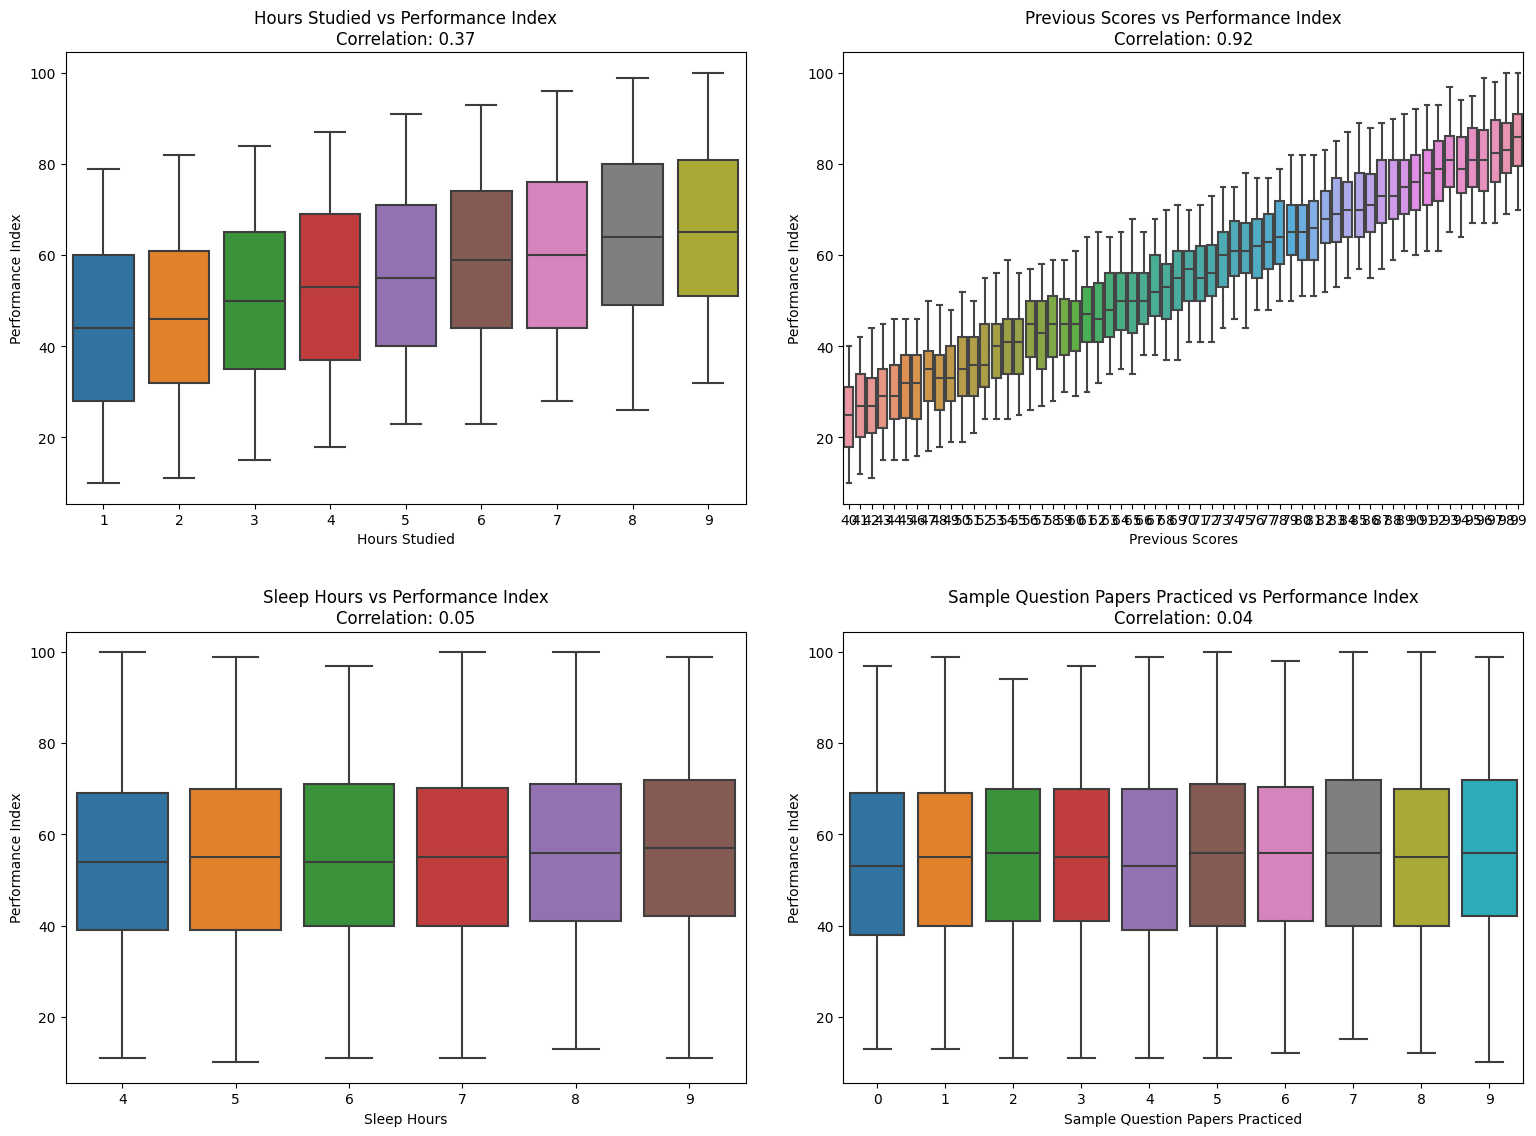

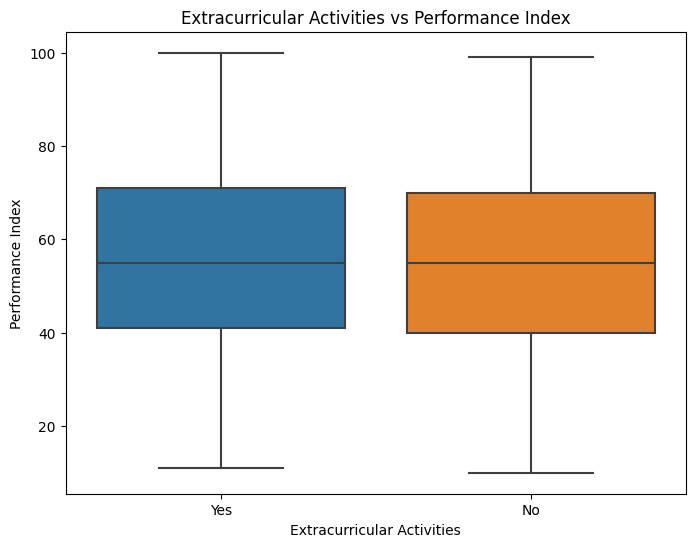

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt

# Get only numeric features for correlation scores
numeric_features = df.select_dtypes(include=['int64', 'float64']).columns.drop('Performance Index')

# Create scatterplots with correlation annotations
plt.figure(figsize=(16, 12))
for i, feature in enumerate(numeric_features, 1):
    plt.subplot(2, 2, i)
    sns.boxplot(x=df[feature], y=df['Performance Index'])
    
    # Calculate and display correlation
    corr = df[feature].corr(df['Performance Index'])
    plt.title(f'{feature} vs Performance Index\nCorrelation: {corr:.2f}')
    plt.xlabel(feature)
    plt.ylabel('Performance Index')
    plt.tight_layout(pad=3.0)

# Boxplot of categorical feature
plt.figure(figsize=(8, 6))
sns.boxplot(x='Extracurricular Activities', y='Performance Index', data=df)
plt.title('Extracurricular Activities vs Performance Index')
plt.show()

### Check the Distribution of Each Column for Skew

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

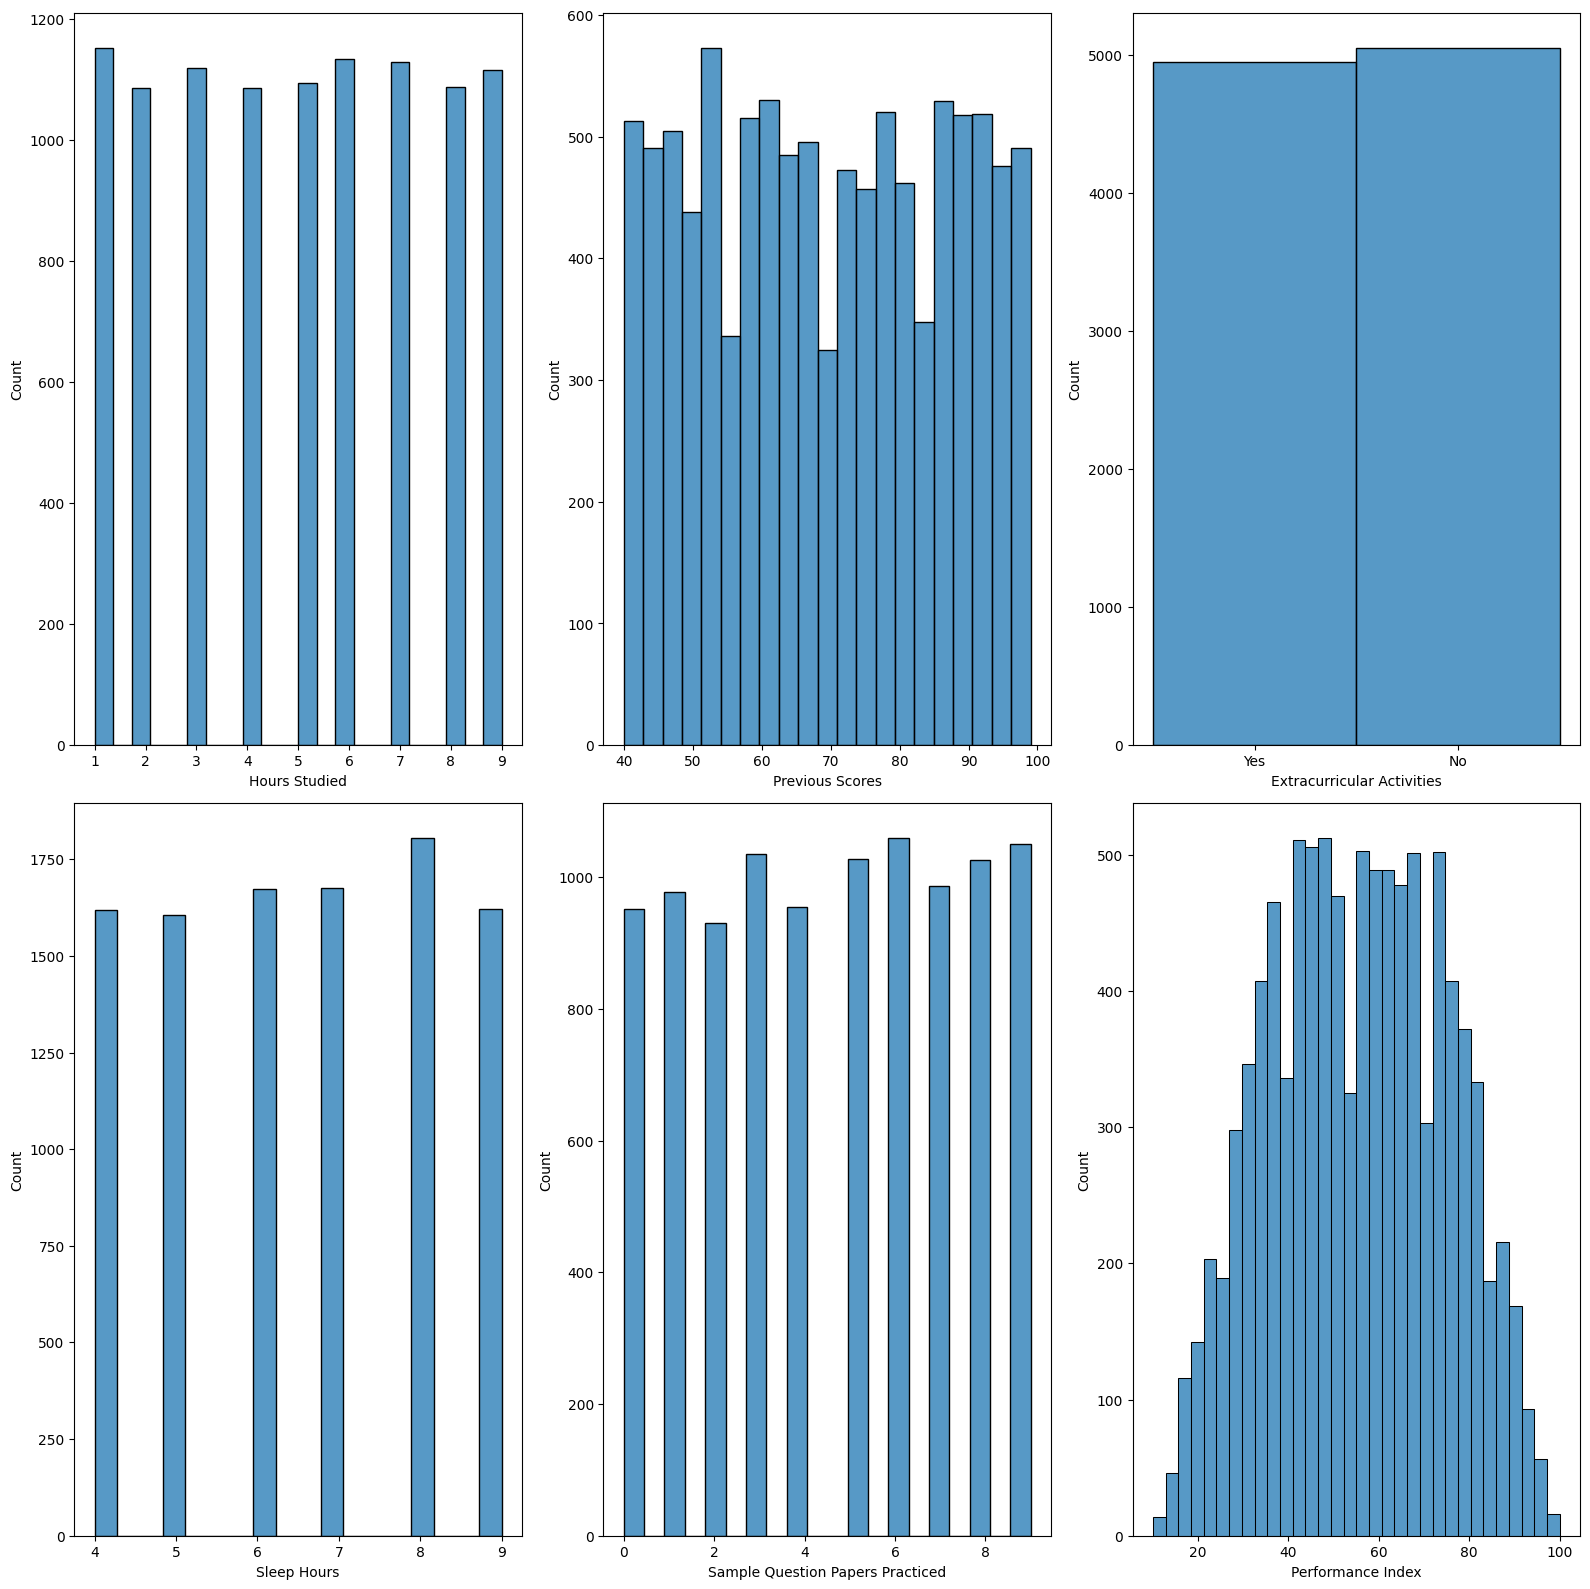

In [4]:
plt.figure(figsize=(16,16))
for i, feature in enumerate(df.columns, 1):
    plt.subplot(2,3,i)
    sns.histplot(data=df, x=df[feature])

plt.tight_layout()
plt.show()

### Feature Engineering

In [5]:
# Interaction terms
df['PrevScore_HoursStudied_Ratio'] = df['Previous Scores'] / (df['Hours Studied'] + 1)
df['PrevScore_Sleep_Ratio'] = df['Previous Scores'] / (df['Sleep Hours'] + 1)
df['PrevScore_Papers_Ratio'] = df['Previous Scores'] / (df['Sample Question Papers Practiced'] + 1)

# Differences (check for performance decay or improvement)
df['PrevScore_HoursStudied_Diff'] = df['Previous Scores'] - df['Hours Studied']
df['PrevScore_Sleep_Diff'] = df['Previous Scores'] - df['Sleep Hours']
df['PrevScore_Papers_Diff'] = df['Previous Scores'] - df['Sample Question Papers Practiced']

# Group by Extracurricular Activities and aggregate
agg_features = df.groupby('Extracurricular Activities')['Previous Scores'].agg(['mean', 'std', 'min', 'max']).reset_index()
agg_features.columns = ['Extracurricular Activities', 'PrevScore_Mean', 'PrevScore_Std', 'PrevScore_Min', 'PrevScore_Max']

# Merge back to the original dataset
df = df.merge(agg_features, on='Extracurricular Activities', how='left')

# Target encoding for Extracurricular Activities
target_mean = df.groupby('Extracurricular Activities')['Performance Index'].mean().to_dict()
df['Activity_Target_Mean'] = df['Extracurricular Activities'].map(target_mean)

# Categorize students based on performance trends
df['Performance_Trend'] = pd.qcut(df['Previous Scores'], q=4, labels=['Low', 'Medium', 'High', 'Top'])

# Interaction with study habits
df['Improvement_Potential'] = (df['Hours Studied'] * df['Sample Question Papers Practiced']) / (df['Previous Scores'] + 1)

# Polynomial features
df['PrevScore_Squared'] = df['Previous Scores'] ** 2
df['PrevScore_Cubed'] = df['Previous Scores'] ** 3

# Identify categorical columns
categorical_cols = df.select_dtypes(include='category').columns

# Convert categorical columns to a suitable type (e.g., object or string)
for col in categorical_cols:
    df[col] = df[col].astype(str)

# Check for infinite values only in numeric columns
numeric_cols = df.select_dtypes(include=[np.number]).columns
    
display(df.head(), df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 21 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   Hours Studied                     10000 non-null  int64  
 1   Previous Scores                   10000 non-null  int64  
 2   Extracurricular Activities        10000 non-null  object 
 3   Sleep Hours                       10000 non-null  int64  
 4   Sample Question Papers Practiced  10000 non-null  int64  
 5   Performance Index                 10000 non-null  float64
 6   PrevScore_HoursStudied_Ratio      10000 non-null  float64
 7   PrevScore_Sleep_Ratio             10000 non-null  float64
 8   PrevScore_Papers_Ratio            10000 non-null  float64
 9   PrevScore_HoursStudied_Diff       10000 non-null  int64  
 10  PrevScore_Sleep_Diff              10000 non-null  int64  
 11  PrevScore_Papers_Diff             10000 non-null  int64  
 12  PrevS

,Hours Studied,Previous Scores,Extracurricular Activities,Sleep Hours,Sample Question Papers Practiced,Performance Index,PrevScore_HoursStudied_Ratio,PrevScore_Sleep_Ratio,PrevScore_Papers_Ratio,PrevScore_HoursStudied_Diff,...,PrevScore_Papers_Diff,PrevScore_Mean,PrevScore_Std,PrevScore_Min,PrevScore_Max,Activity_Target_Mean,Performance_Trend,Improvement_Potential,PrevScore_Squared,PrevScore_Cubed
0,7,99,Yes,9,1,91.0,12.375000,9.900000,49.500000,92,...,98,69.592361,17.361091,40,99,55.700889,Top,0.070000,9801,970299
1,4,82,No,4,2,65.0,16.400000,16.400000,27.333333,78,...,80,69.302059,17.326080,40,99,54.758511,High,0.096386,6724,551368
2,8,51,Yes,7,2,45.0,5.666667,6.375000,17.000000,43,...,49,69.592361,17.361091,40,99,55.700889,Low,0.307692,2601,132651
3,5,52,Yes,5,2,36.0,8.666667,8.666667,17.333333,47,...,50,69.592361,17.361091,40,99,55.700889,Low,0.188679,2704,140608
4,7,75,No,8,5,66.0,9.375000,8.333333,12.500000,68,...,70,69.302059,17.326080,40,99,54.758511,High,0.460526,5625,421875


None

### Label Encode Categorical Feature and Plot Corr. Matrix for Multicollinearity Between Features

In [6]:
from sklearn.preprocessing import LabelEncoder

# Replace infinities with NaN
df.replace([np.inf, -np.inf], np.nan, inplace=True)

# Use loc to avoid chained assignment
df.loc[:, "Extracurricular Activities"] = df["Extracurricular Activities"].fillna("Unknown")
df.loc[:, "Performance_Trend"] = df["Performance_Trend"].fillna("Unknown")

# Label Encoding
#le = LabelEncoder()
#df["Extracurricular Activities"] = le.fit_transform(df["Extracurricular Activities"].astype(str))
#df["Performance_Trend"] = le.fit_transform(df["Performance_Trend"].astype(str))

/usr/local/lib/python3.10/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


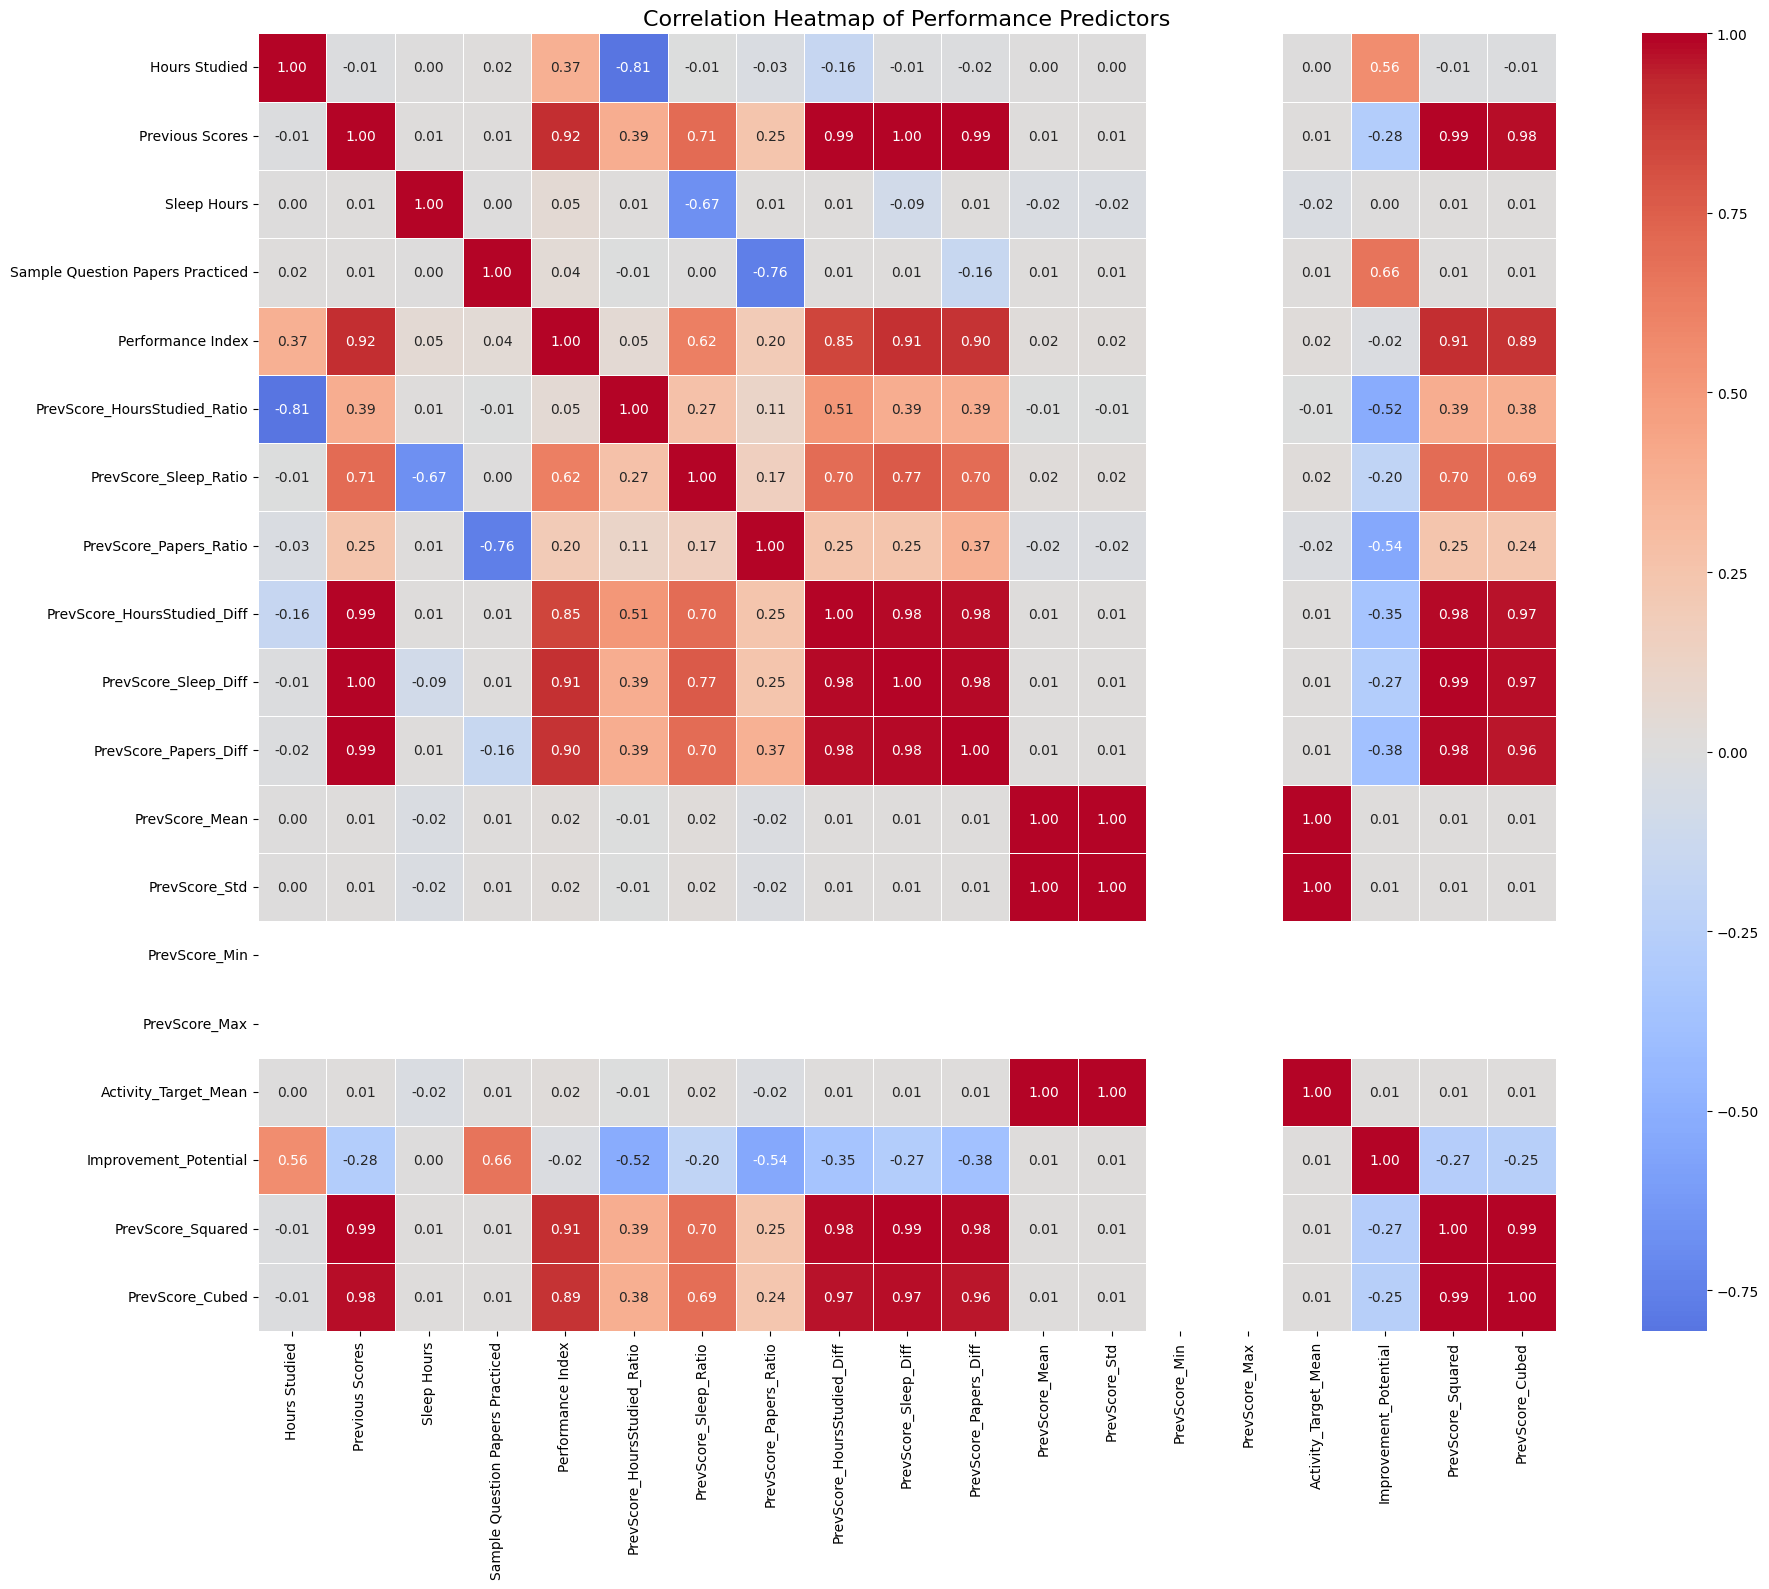

In [7]:
# Select only numeric columns for correlation
numeric_columns = df.select_dtypes(include=['int64', 'float64']).columns
correlation_matrix = df[numeric_columns].corr()

# Create a large figure to accommodate many features
plt.figure(figsize=(20, 16))

# Create heatmap
sns.heatmap(correlation_matrix, 
            cmap='coolwarm',  # Blue-white-red color palette
            annot=True,       # Show correlation values
            cbar=True,        # Color bar on the side
            square=True,      # Make plot square
            fmt='.2f',        # Format correlation values to 2 decimal places
            linewidths=0.5,   # Add lines between cells
            center=0)         # Center color scale at 0

plt.title('Correlation Heatmap of Performance Predictors', fontsize=16)
plt.tight_layout()
plt.show()

In [8]:
# Label Encoding
le = LabelEncoder()
df["Extracurricular Activities"] = le.fit_transform(df["Extracurricular Activities"].astype(str))
df["Performance_Trend"] = le.fit_transform(df["Performance_Trend"].astype(str))

### Split Data

In [9]:
from sklearn.model_selection import train_test_split

X = df.drop(columns="Performance Index")
y = df["Performance Index"]

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.2, random_state = 42)

### Scale Data

In [10]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

ss = StandardScaler()
X_train_scaled = ss.fit_transform(X_train)
X_val_scaled = ss.transform(X_val)
X_train_scaled = pd.DataFrame(X_train_scaled, columns = X_train.columns)
X_val_scaled = pd.DataFrame(X_val_scaled, columns = X_val.columns)

### Feature Selection Using MI Scores

In [11]:
from sklearn.feature_selection import SelectKBest, mutual_info_regression

selector = SelectKBest(mutual_info_regression, k = 'all')
X_train_MI = selector.fit_transform(X_train_scaled, y_train)
X_train_MI = pd.DataFrame(X_train_MI, columns=X_train.columns[selector.get_support()])
X_train_MI.head()

,Hours Studied,Previous Scores,Extracurricular Activities,Sleep Hours,Sample Question Papers Practiced,PrevScore_HoursStudied_Ratio,PrevScore_Sleep_Ratio,PrevScore_Papers_Ratio,PrevScore_HoursStudied_Diff,PrevScore_Sleep_Diff,PrevScore_Papers_Diff,PrevScore_Mean,PrevScore_Std,PrevScore_Min,PrevScore_Max,Activity_Target_Mean,Performance_Trend,Improvement_Potential,PrevScore_Squared,PrevScore_Cubed
0,0.006455,-1.183844,-0.989307,0.269888,0.134041,-0.702663,-1.052476,-0.606271,-1.169910,-1.204484,-1.191926,-0.989307,-0.989307,0.0,0.0,-0.989307,-0.420269,0.456295,-1.127271,-1.055060
1,-1.149747,-1.241506,1.010808,0.269888,0.483562,0.098155,-1.088871,-0.674944,-1.056038,-1.261869,-1.305907,1.010808,1.010808,0.0,0.0,1.010808,-0.420269,-0.318696,-1.167261,-1.081535
2,-1.149747,0.661318,-0.989307,0.269888,-0.914520,1.222709,0.112167,0.381365,0.822856,0.631849,0.802738,-0.989307,-0.989307,0.0,0.0,-0.989307,-1.314934,-0.914493,0.587757,0.497332
3,-1.149747,-1.356828,-0.989307,-0.318906,-1.264041,0.030001,-0.922493,0.171601,-1.169910,-1.319255,-1.134935,-0.989307,-0.989307,0.0,0.0,-0.989307,-0.420269,-0.933411,-1.244767,-1.131267
4,1.162658,-1.299167,-0.989307,1.447477,-1.613561,-1.003680,-1.467380,1.430182,-1.454591,-1.434026,-1.020955,-0.989307,-0.989307,0.0,0.0,-0.989307,-0.420269,-1.062686,-1.206426,-1.106930


### Train, Predict, and Evaluate Model using MAE and R2

In [12]:
from xgboost import XGBRegressor, plot_importance
from sklearn.metrics import mean_absolute_error, r2_score

model = XGBRegressor(n_estimators=150, max_depth=5, learning_rate=0.05, colsample_bytree = 0.85, 
                     gamma = 0.5, objective = "reg:squarederror", random_state = 42)
model.fit(X_train_MI, y_train)

y_preds = model.predict(X_val_scaled[X_train_MI.columns])

mae = mean_absolute_error(y_val, y_preds)
print(f"Mean Absolute Error: {mae}")

r2 = r2_score(y_val, y_preds)
print(f"R_2 Score: {r2}")

results_df = pd.DataFrame({'Actual': y_val, 'Predicted': y_preds})
print(results_df.head())

Mean Absolute Error: 1.6448532371520996
R_2 Score: 0.9885250813278524
      Actual  Predicted
6252    51.0  55.264816
4684    20.0  21.999109
1731    46.0  48.124371
4742    28.0  30.595947
4521    41.0  42.652805


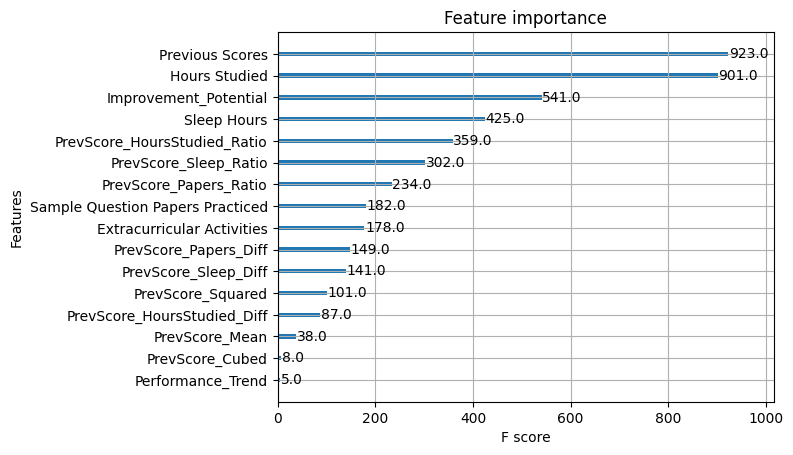

In [13]:
plot_importance(model)
plt.show()